Import all required libraries

In [1]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

Let's define some helper functions that will assist during camera calibration and perspective transformation:

In [2]:
#Wrapper for converting to grayscale
def RGB2GRAY(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

#Undistort an image
def undistort(img, img_points, obj_points, mtx, dist):
    gray = RGB2GRAY(img)
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_img

#Draw a polgon in red showing the region bounded by the source points
def draw_ROI(img, vertices):
    masked_img = np.copy(img)
    return cv2.polylines(masked_img, np.int32([vertices]), 1, color = 255, thickness=3, lineType=4)

#Warp the image to get a plan view
def warp_image(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    img = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    return img

Let's define some additional funtions that will help with the color and gradient thresholding:

In [3]:
#Wrapper for converting to HLS
def RGB2HLS(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return img

#Wrapper for converting Gray to RGB
def GRAY2RGB(img):
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img

def cvtThresholdBinary(img, threshold):
    img  = np.uint8(255*img/np.max(img))
    binary_img = np.zeros_like(img)
    binary_img[(img >= threshold[0]) & (img <= threshold[1])] = 1
    return binary_img

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = RGB2GRAY(img)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        print("ERROR: Incorrect gradient orientation selected. Grayscale image returned")
        sobel = gray
    abs_sobel = np.absolute(sobel)
    binary_img = cvtThresholdBinary(abs_sobel, thresh)
    return binary_img

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = RGB2GRAY(img)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    binary_img = cvtThresholdBinary(abs_sobel, mag_thresh)
    return binary_img

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = RGB2GRAY(img)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    dir_grad = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_img = np.zeros_like(dir_grad)
    binary_img[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    return binary_img

def HLS_threshold(img, channel='S', thresh=(0,255)):
    img = RGB2HLS(img)
    H,L,S = cv2.split(img)
    binary_img = np.zeros_like(S)
    if channel == 'S':
        #binary_img = cvtThresholdBinary(S, thresh)
        binary_img[(S > thresh[0]) & (S <= thresh[1])] = 1
    elif channel == 'H':
        #binary_img = cvtThresholdBinary(H, thresh)
        binary_img[(H > thresh[0]) & (H <= thresh[1])] = 1
    else:
        print("ERROR: Incorrect channel selected, empty image returned")
    return binary_img

#References:
#https://medium.com/towards-data-science/
#robust-lane-finding-using-advanced-computer-vision-techniques-mid-project-update-540387e95ed3
def white_selector(img):
    #img = RGB2HLS(img)
    #lower_white_threshold = np.array([0,200,0], dtype = np.uint8)
    #upper_white_threshold = np.array([255,255,255], dtype = np.uint8)
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_white_threshold = np.array([0,0,200], dtype = np.uint8)
    upper_white_threshold = np.array([255,30,255], dtype = np.uint8)
    
    binary_img = cv2.inRange(img, lower_white_threshold, upper_white_threshold)
    return binary_img/255

#References:
#http://aishack.in/tutorials/tracking-colored-objects-opencv/
#https://medium.com/@royhuang_87663/how-to-find-threshold-f05f6b697a00
def yellow_selector(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #img = RGB2HLS(img)
    #lower_yellow_threshold = np.uint8([ 10,   0, 100])
    #upper_yellow_threshold = np.uint8([ 40, 255, 255])
    lower_yellow_threshold = np.asarray([10, 100, 100]) #HSV threshold S 20-70%
    upper_yellow_threshold = np.asarray([50, 255, 255]) #HSV threshold
    binary_img = cv2.inRange(img, lower_yellow_threshold, upper_yellow_threshold)
    #binary_img = cv2.bitwise_and(img, img, mask=mask)
    return binary_img/255

#Perform CLAHE Equalizations
def clahe_equalize(img):
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16,16))
    y, u, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2YUV))
    y = clahe.apply(y)
    img = cv2.merge((y,u,v))
    img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)
    return img

def OR_binaries(img1, img2):
    new_img = np.zeros_like(img1)
    new_img[(img1 == 1) | (img2 == 1)] = 1
    return new_img

def AND_binaries(img1, img2):
    new_img = np.zeros_like(img1)
    new_img[(img1 == 1) & (img2 == 1)] = 1
    return new_img

def blur_gradient(img):
    blur = cv2.GaussianBlur(img,(5,5),0)
    return blur

Let's start by calibrating the camera:

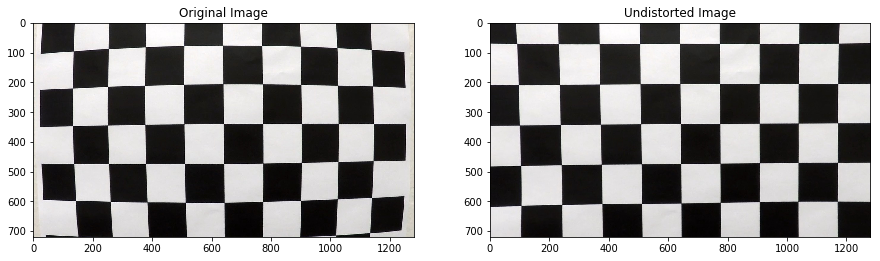

In [4]:
cal_images = glob('.\\camera_cal\calibration*.jpg')
n_cal_images = len(cal_images)

#Chessboard Size
nx = 9
ny = 6

img_points = [] # 2D points in image
obj_points = [] # 3D points in real-world space

objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

#Read in all images and append to image points and object points arrays
for image_path in cal_images:
    image = mpimg.imread(image_path)
    gray = RGB2GRAY(image)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        img_points.append(corners)
        obj_points.append(objp)
    image = cv2.drawChessboardCorners(image, (nx,ny), corners, ret)
    #plt.imshow(image)
    #plt.savefig(image_path.split('\\')[2].split('.')[0] + '_cal.jpg')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)

#Test the undistortion
test_image = mpimg.imread('.\\camera_cal\\test_image.jpg')
undist_img = undistort(test_image, img_points, obj_points, mtx, dist)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(undist_img)
plt.title('Undistorted Image')
plt.show()

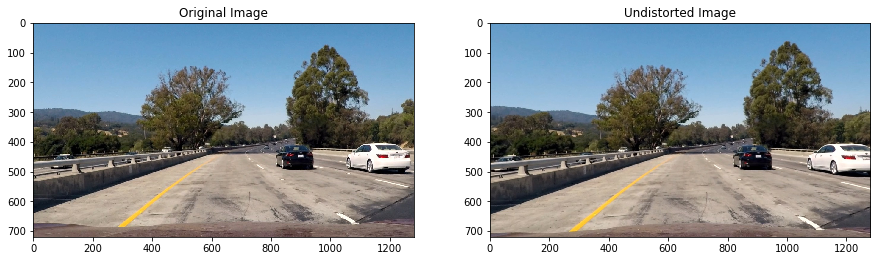

In [84]:
#Test the undistortion
test_image = mpimg.imread('.\\test_images\\test1.jpg')
undist_img = undistort(test_image, img_points, obj_points, mtx, dist)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(undist_img)
plt.title('Undistorted Image')
plt.show()

Now let's do a perspective transform to get a bird's eye view:

Image shape is: (720, 1280, 3)
Left line gradient:0.440
Right line gradient:0.440


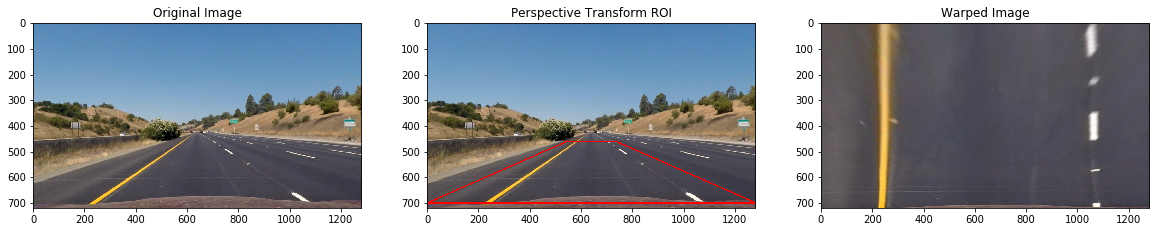

In [95]:
image = mpimg.imread('.\\test_images\\test01.jpg')
image = undistort(image, img_points, obj_points, mtx, dist)
image_size = (image.shape[1], image.shape[0])
y_top = 460
y_bottom = 700
xl_bottom = 0
#xl_bottom = 145
xl_top = 545
#xr_bottom = 1195
xr_bottom = 1280
xr_top = 735

print("Image shape is:", image.shape)
src_points = np.float32([[xl_bottom, y_bottom], [xl_top, y_top], [xr_top, y_top], [xr_bottom, y_bottom]])
dst_points = np.float32([[xl_bottom,image.shape[0]], [xl_bottom, 0], 
                         [xr_bottom, 0], [xr_bottom, image.shape[0]]])
masked_image = draw_ROI(image, src_points)
print("Left line gradient:{:.3f}".format(np.abs((y_top-y_bottom)/(xl_top-xl_bottom))))
print("Right line gradient:{:.3f}".format(np.abs((y_bottom-y_top)/(xr_bottom-xr_top))))

warped_image = warp_image(image, src_points, dst_points)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(masked_image)
plt.title('Perspective Transform ROI')
plt.subplot(1,3,3)
plt.imshow(warped_image)
plt.title('Warped Image')
#plt.savefig('.\\output_images\\perspective_transform.jpg')
plt.show()

Let's examine the various color and gradient thresholds to determine what to use for lane selection:

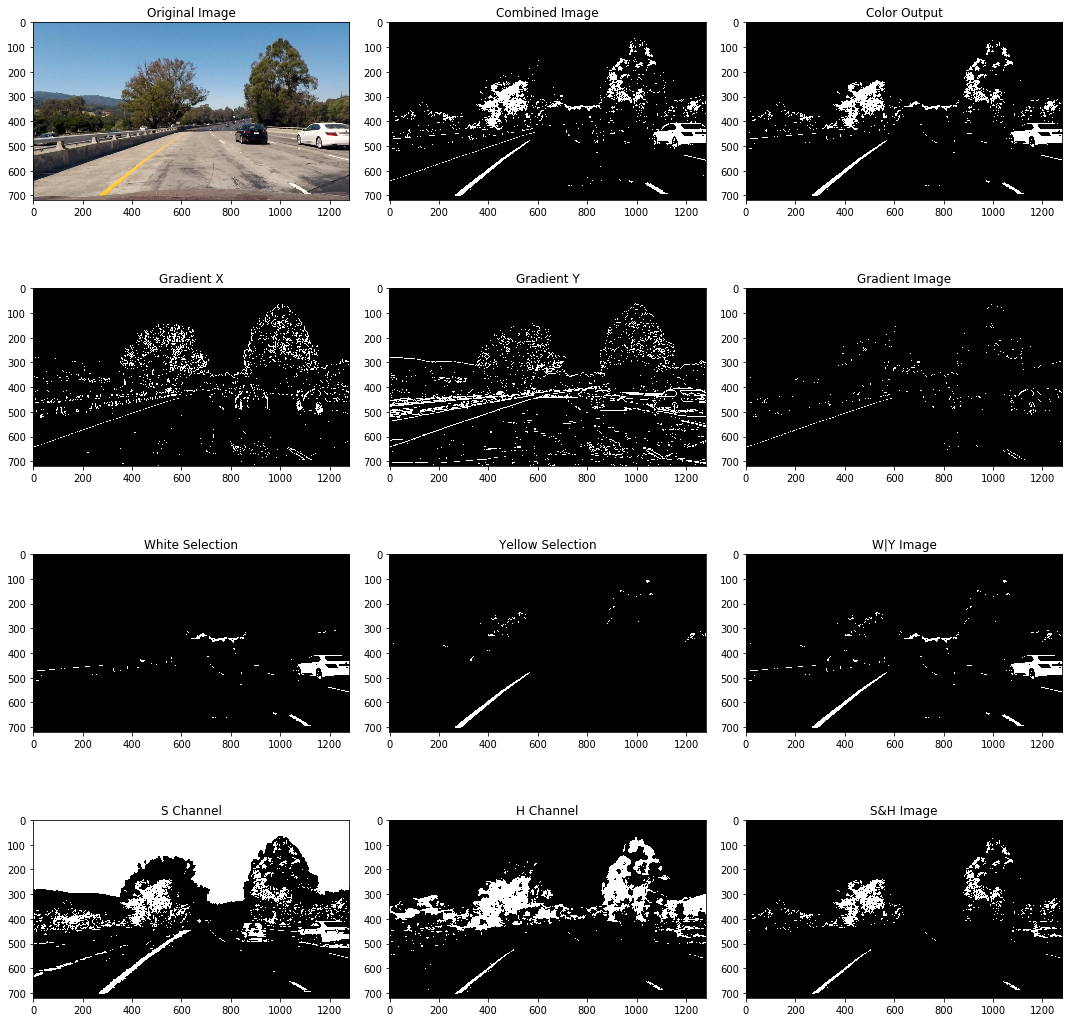

In [87]:
image = mpimg.imread('.\\test_images\\test1.jpg')
image = undistort(image, img_points, obj_points, mtx, dist)

sobel_thresh = (25, 255)
mag_thresh = (50, 100)
dir_thresh = (0.7, 1.3)
S_thresh = (80, 255)
H_thresh= (20, 30)

x_binary = abs_sobel_thresh(image, 'x', 5, sobel_thresh)
y_binary = abs_sobel_thresh(image, 'y', 3, sobel_thresh)
mag_binary = mag_threshold(image, 7, mag_thresh)
dir_binary = dir_threshold(image, 15, dir_thresh)
S_binary = HLS_threshold(image, 'S', S_thresh)
H_binary = HLS_threshold(image, 'H', H_thresh)
W_binary = white_selector(image)
Y_binary = yellow_selector(image)

color_output = OR_binaries(OR_binaries(W_binary, Y_binary), AND_binaries(S_binary, H_binary))
SH_binary = AND_binaries(S_binary, H_binary)
WY_binary = OR_binaries(W_binary, Y_binary)
mag_output = AND_binaries(mag_binary, dir_binary)
grad_output = blur_gradient(AND_binaries(x_binary, y_binary))
output = OR_binaries(color_output, grad_output)

nrows, ncols = 4, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))

plt.subplot(nrows,ncols,1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(nrows,ncols,2)
plt.imshow(output, cmap = 'gray')
plt.title('Combined Image')
plt.subplot(nrows,ncols,3)
plt.imshow(color_output, cmap = 'gray')
plt.title('Color Output')
plt.subplot(nrows,ncols,4)
plt.imshow(x_binary, cmap = 'gray')
plt.title('Gradient X')
plt.subplot(nrows,ncols,5)
plt.imshow(y_binary, cmap = 'gray')
plt.title('Gradient Y')
plt.subplot(nrows,ncols,6)
plt.imshow(grad_output, cmap = 'gray')
plt.title('Gradient Image')
plt.subplot(nrows,ncols,7)
plt.imshow(W_binary, cmap = 'gray')
plt.title('White Selection')
plt.subplot(nrows,ncols,8)
plt.imshow(Y_binary, cmap = 'gray')
plt.title('Yellow Selection')
plt.subplot(nrows,ncols,9)
plt.imshow(WY_binary, cmap = 'gray')
plt.title('W|Y Image')
plt.subplot(nrows,ncols,10)
plt.imshow(S_binary, cmap = 'gray')
plt.title('S Channel')
plt.subplot(nrows,ncols,11)
plt.imshow(H_binary, cmap = 'gray')
plt.title('H Channel')
plt.subplot(nrows,ncols,12)
plt.imshow(SH_binary, cmap = 'gray')
plt.title('S&H Image')

fig.tight_layout()
#plt.savefig('.\\output_images\\threshold_image.jpg')
plt.show()

Let's look at the output images for all the test images:

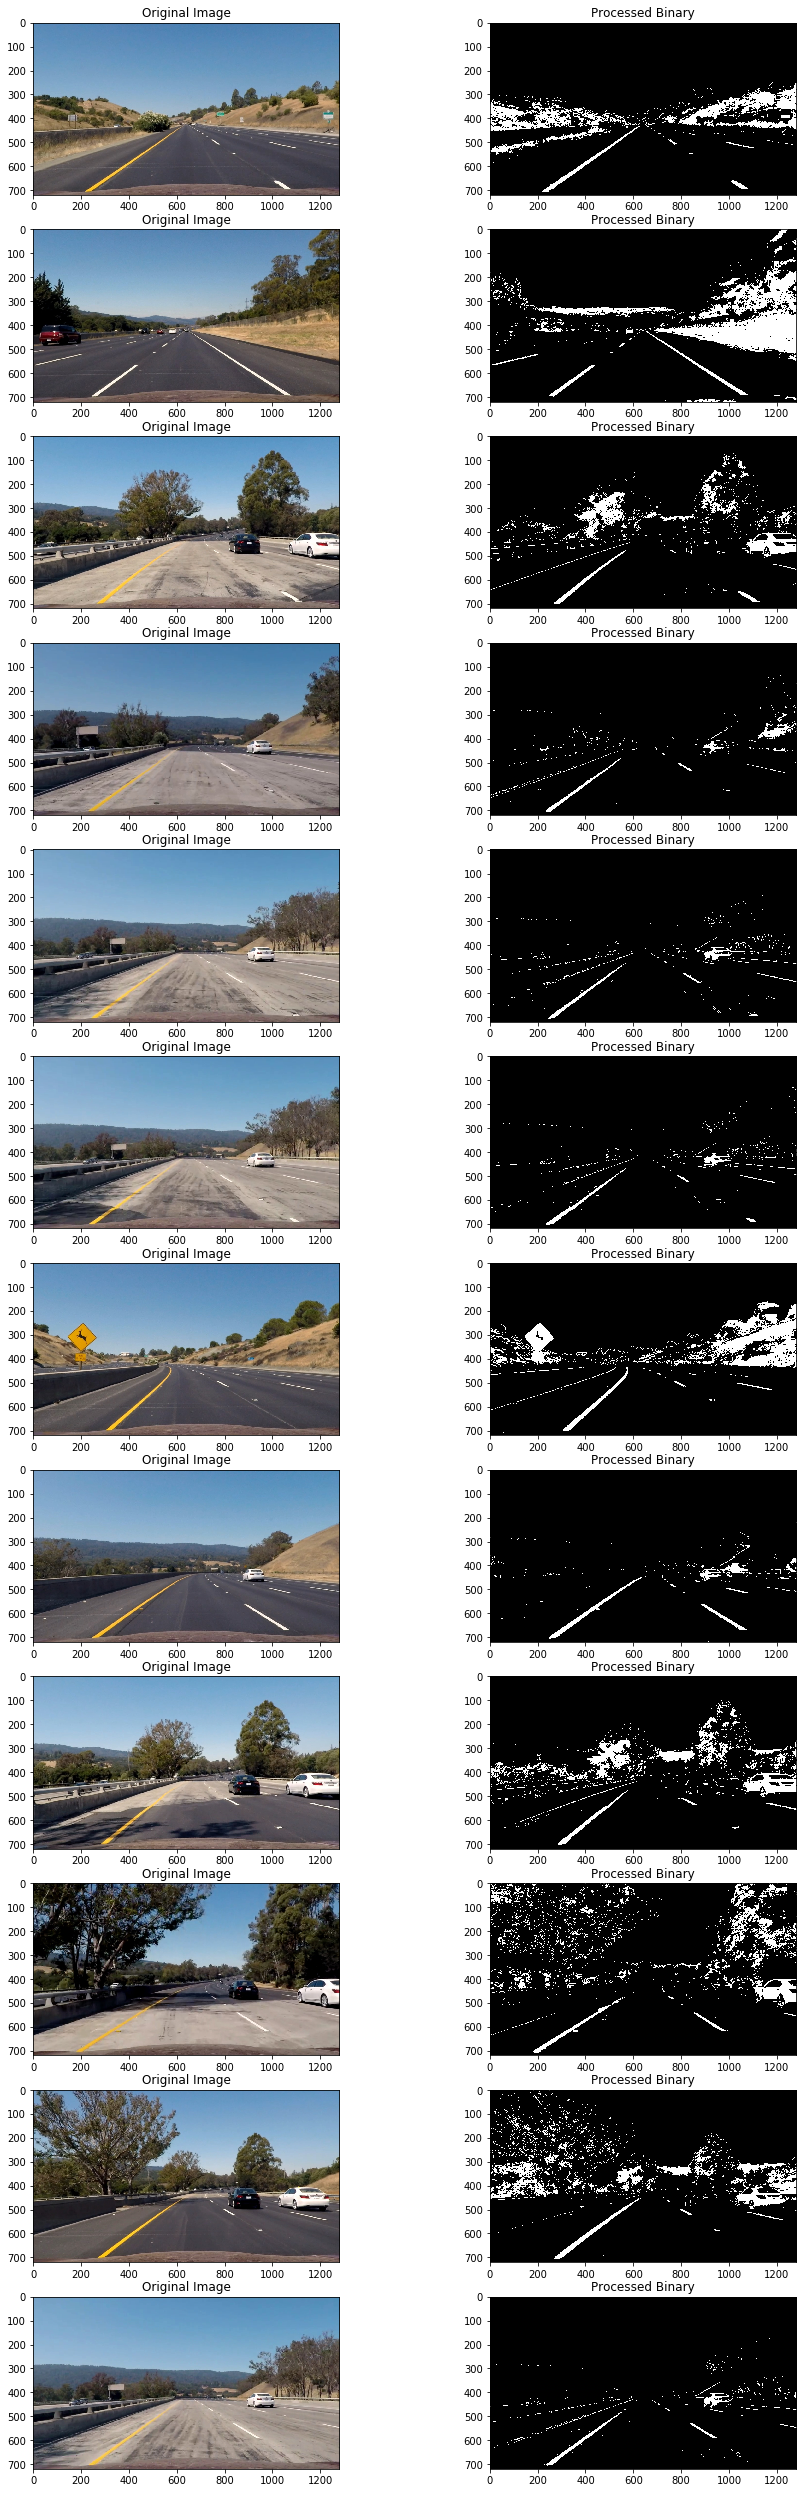

In [97]:
test_images = glob('.\\test_images\\test*.jpg')
n_images = len(test_images)

nrows, ncols = n_images, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(15,45))

for i, image_path in enumerate(test_images):
    #Read in the image and undistort it
    image = mpimg.imread(image_path)
    image = undistort(image, img_points, obj_points, mtx, dist)
    
    #Create the output image
    x_binary = abs_sobel_thresh(image, 'x', 5, sobel_thresh)
    y_binary = abs_sobel_thresh(image, 'y', 3, sobel_thresh)
    S_binary = HLS_threshold(image, 'S', S_thresh)
    H_binary = HLS_threshold(image, 'H', H_thresh)
    W_binary = white_selector(image)
    Y_binary = yellow_selector(image)
    color_output = OR_binaries(OR_binaries(W_binary, Y_binary), AND_binaries(S_binary, H_binary))
    SH_binary = AND_binaries(S_binary, H_binary)
    WY_binary = OR_binaries(W_binary, Y_binary)
    mag_output = AND_binaries(mag_binary, dir_binary)
    grad_output = blur_gradient(AND_binaries(x_binary, y_binary))
    output = OR_binaries(color_output, grad_output)
    
    #Plot the results
    plt.subplot(nrows,ncols, 2*i + 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.subplot(nrows,ncols, 2*i + 2)
    plt.imshow(output, cmap = 'gray')
    plt.title("Processed Binary")
    
#plt.savefig('.\\output_images\\pipeline_test.jpg') 

Now let's put together the pipeline and see what the warped images look like after color/gradient thresholding:

In [78]:
def scan_slice(img_slice, conv_win):
    
    image_mid = int(img_slice.shape[0]/2) #used to scan the left and right halfs of the slice separately
    l_conv_output = np.convolve(conv_win, img_slice[:image_mid]) 
    l_center = np.argmax(l_conv_output)
    #Drop the result if the max value is less than a threshold
    if l_conv_output[l_center] < 10:
        l_center = 0
    #print("Raw slice left center is:", l_center)
    r_conv_output = np.convolve(conv_win, img_slice[image_mid:])
    r_center = np.argmax(r_conv_output)
    #Drop the result if the max value is less than a threshold
    if r_conv_output[r_center] < 10:
        r_center = 0
    #print("Raw slice right center is:", r_center)
    return l_center, r_center

def scan_margin(img_slice, conv_win, margin, xl, xr):
    offset = int(len(conv_win)/2)
    conv_output = np.convolve(conv_win, img_slice) 
    #Initialize centers to zero in case both input values are zero
    l_center = 0
    r_center = 0
    #Perform margin scan only if input values are non-zero
    if xl != 0:
        #Define boundaries for left line scan & limit left line from 0 to middle of slice
        l_min_index = int(max(xl+offset-margin,0))
        l_max_index = int(min(xl+offset+margin,img_slice.shape[0]/2))
        l_center = np.argmax(conv_output[l_min_index:l_max_index])+l_min_index
        #Set returned values to 0 if nothing is found in margin scan to trigger a slice scan
        if l_center == l_min_index:
            l_center = 0
        #print("Raw margin left center is:", l_center)
    
    if xr != 0:
        #Define boundaries for right line scan and limit right line from middle to end of slice 
        r_min_index = int(max(xr+offset-margin,img_slice.shape[0]/2))
        r_max_index = int(min(xr+offset+margin,img_slice.shape[0]))
        r_center = np.argmax(conv_output[r_min_index:r_max_index])+r_min_index
        #Set returned values to 0 if nothing is found in margin scan to trigger a slice scan
        if r_center == r_min_index:
            r_center = 0
        #print("Raw margin right center is:", r_center)
    
    return l_center, r_center

def find_centers(img):
    
    n_windows = 8 #should divide 720 evenly - 6, 8, 9, 12 - # of slices into which the image will be split 
    window_height = img.shape[0]/n_windows #height of the convolution window/image slice
    image_mid = int(img.shape[1]/2)
    window_width = 45 #width of the convolution window
    offset = window_width/2 #used to re-position the center after performing the convolution
    margin = 50 #margin around which to scan for lane lines
    thresh = 10

    l_centers = [] #left lane line center points [xl, y] are stored from the bottom to the top of an image
    r_centers = [] #right lane line center points [xr, y] are stored from the bottom to the top of an image
    conv_win = np.ones(window_width) #define the convolution window
    
    #Find the centers starting at the bottom of the image to use as a starting point
    image_base_slice = np.sum(img[int((n_windows - 1)*img.shape[0]//n_windows):
                                  int((n_windows)*img.shape[0]//n_windows),:], axis=0)
    
    #Find base x-coordinates and append only if a peak is found
    xl, xr = scan_slice(image_base_slice, conv_win)
    y = img.shape[0] - int(window_height/2)
    if (xl != 0):
        xl = xl - offset
        l_centers.append([xl, y])
        #print("Left base point appended")
        
    if (xr != 0):
        xr = xr - offset + image_mid
        r_centers.append([xr, y])
        #print("Right base point appended")
        
    #Iterate over the levels moving up from the bottom of the image
    for level in np.arange(1, n_windows):
        image_slice = np.sum(img[int((n_windows - level - 1)*img.shape[0]//n_windows):
                                  int((n_windows - level)*img.shape[0]//n_windows),:], axis=0)
        
        #Scan around a margin to find the center point for the next level
        y = int((n_windows - level - 1)*img.shape[0]//n_windows + window_height/2)
        xl, xr = scan_margin(image_slice, conv_win, margin, xl, xr)
        #Do a full slice scan if margin scan doesn't return any values
        if (xl == 0) | (xr == 0):
            #print("Margin scan failed. Scanning slice.", xl, xr)
            xl, xr = scan_slice(image_slice, conv_win)
            
            #Append points only if a peak is found
            if xl != 0:
                xl = xl - offset
                l_centers.append([xl, y])
                #print("Slice left point {:d} appended".format(level))

            if xr != 0:
                xr = xr - offset + image_mid
                r_centers.append([xr, y])
                #print("Slice right point {:d} appended".format(level))
        else:
            xl = xl - offset
            xr = xr - offset #+ image_mid
            l_centers.append([xl, y])
            r_centers.append([xr, y])
            #print("Margin left & right points {:d} appended".format(level))
            
    return np.asarray(l_centers, dtype=np.int32), np.asarray(r_centers, dtype=np.int32)
    
def draw_lines(img, l_centers, r_centers):
    #Create a copy of the image to work on
    img_copy = np.zeros_like(img)
    
    #Find the co-efficients for the left and right lines
    deg = 2
    l_coeff = np.polyfit(l_centers[:,1], l_centers[:,0], deg)
    r_coeff = np.polyfit(r_centers[:,1], r_centers[:,0], deg)
    
    #Calculate the line points for each pixel
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_line = l_coeff[0]*ploty**deg + l_coeff[1]*ploty + l_coeff[2]
    right_line = r_coeff[0]*ploty**deg + r_coeff[1]*ploty + r_coeff[2]
    
    #Reshape the arrays into (x,y) coordinates that can be used by cv2 functions
    ploty = ploty.reshape((len(ploty),1))
    left_line = left_line.reshape((len(ploty),1))
    right_line = right_line.reshape((len(ploty),1))
    left_pts = np.concatenate([left_line, ploty], axis = 1)
    right_pts = np.concatenate([right_line, ploty], axis = 1)
    
    #Draw lane boundaries and region
    poly_pts = np.concatenate([left_pts, right_pts[::-1]], axis = 0)
    img_copy = cv2.polylines(img_copy, np.int32([left_pts]), 0, color = (0,255,0), thickness=20, lineType=4)
    img_copy = cv2.polylines(img_copy, np.int32([right_pts]), 0, color = (0,255,0), thickness=20, lineType=4)
    img_copy = cv2.fillPoly(img_copy, np.int32([poly_pts]), color = (0,100,0), lineType=8)
    
    #Convert from pixel space to real space
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_line_cr = np.polyfit(l_centers[:,1]*ym_per_pix, l_centers[:,0]*xm_per_pix, 2)
    right_line_cr = np.polyfit(r_centers[:,1]*ym_per_pix, r_centers[:,0]*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    y_eval = img.shape[0]
    left_ROC = ((1 + (2*left_line_cr[0]*y_eval*ym_per_pix + left_line_cr[1])**2)**1.5) / np.absolute(2*left_line_cr[0])
    right_ROC = ((1 + (2*right_line_cr[0]*y_eval*ym_per_pix + right_line_cr[1])**2)**1.5) / np.absolute(2*right_line_cr[0])
    ROC = (left_ROC + right_ROC)/2
    
    #Measure offset
    x_left = l_coeff[0]*y_eval**deg + l_coeff[1]*y_eval + l_coeff[2]
    x_right = r_coeff[0]*y_eval**deg + r_coeff[1]*y_eval + r_coeff[2]
    lane_center = int((x_left + x_right)/2)
    image_center = int(image.shape[1]/2)
    offset = (lane_center - image_center) * xm_per_pix
    
    return img_copy, offset, ROC, left_line, right_line, ploty

def check_centers(l_centers, r_centers, z_score):
    l_mu = np.mean(l_centers[:,0])
    r_mu = np.mean(r_centers[:,0])
    l_sig = np.std(l_centers[:,0])
    r_sig = np.std(r_centers[:,0])
    
    lz_score = np.abs(l_centers[:,0] - l_mu)/l_sig
    rz_score = np.abs(r_centers[:,0] - r_mu)/r_sig
    
    return l_centers[lz_score<z_score], r_centers[rz_score<z_score]
    
    
def process_image(img, img_points, obj_points, mtx, dist, src, dst):
    #Define constants & thresholds
    S_thresh = (80, 255)
    H_thresh= (20, 30)
    sobel_thresh = (25, 255)
    z_score1 = 1.9
    z_score2 = 2.3
    
    #Undistort the image
    img = undistort(img, img_points, obj_points, mtx, dist)
    
    #Find X,Y gradients and apply blurring
    x_binary = abs_sobel_thresh(img, 'x', 5, sobel_thresh)
    y_binary = abs_sobel_thresh(img, 'y', 3, sobel_thresh)
    grad_output = blur_gradient(AND_binaries(x_binary, y_binary))
    
    #Select white/yellow colors, threshold S-channel and combine
    W_binary = white_selector(img)
    Y_binary = yellow_selector(img)
    S_binary = HLS_threshold(img, 'S', S_thresh)
    H_binary = HLS_threshold(img, 'H', H_thresh)
    color_output = OR_binaries(OR_binaries(W_binary, Y_binary), AND_binaries(S_binary, H_binary))
    
    #Combine Color and Gradient image portions to obtain final image to warp
    output = OR_binaries(color_output, grad_output) 
    
    #Warp Image
    warped_img = warp_image(output, src, dst)
    
    #Find centroids and drop outliers (2-passes)
    l_centers, r_centers = find_centers(warped_img)
    l_centers, r_centers = check_centers(l_centers, r_centers, z_score1)
    #l_centers, r_centers = check_centers(l_centers, r_centers, z_score2)
        
    #Draw Lines & measure RoC
    warped_orig = warp_image(img, src, dst)
    warped_lines_img, offset, ROC, left_line, right_line, ploty = draw_lines(warped_orig, l_centers, r_centers)
    
    #Unwarp Image
    unwarped_img = warp_image(warped_lines_img, dst, src)
    
    #Combine images
    output_frame = cv2.addWeighted(img, 1, unwarped_img, 1, 0)
    #Add text to iamge
    cv2.putText(output_frame,"Offset: {:0.2f} m.".format(offset), (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    cv2.putText(output_frame,"RoC: {:0.2f} m.".format(ROC), (50,140), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    
    return warped_img, output_frame, left_line, right_line, ploty, l_centers, r_centers

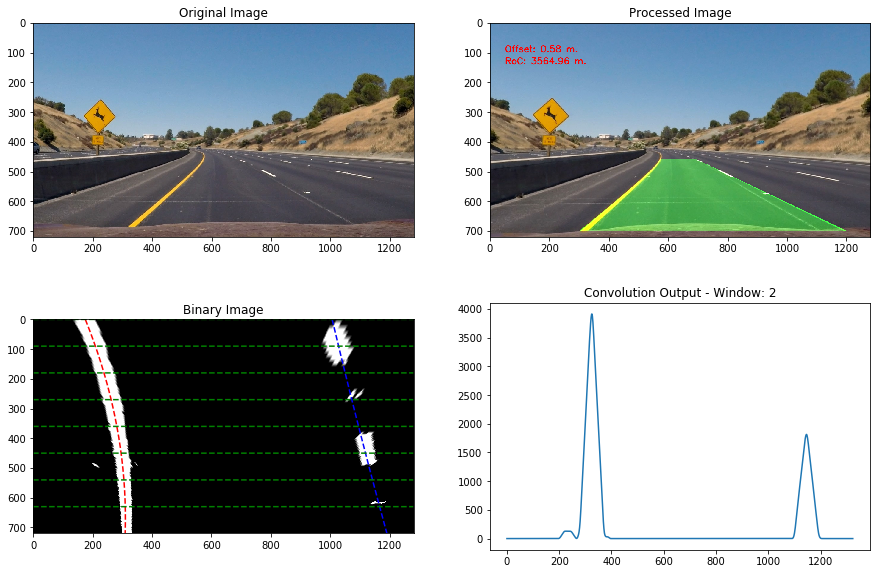

In [110]:
image = mpimg.imread('.\\test_images\\test2.jpg')
proc_image, lines_image, left_line, right_line, ploty, l_centers, r_centers = process_image(image, img_points, obj_points, mtx, dist, src_points, dst_points)

n_windows = 8 #should divide 720 evenly - 6, 8, 9, 12
window_height = proc_image.shape[0]/n_windows
window_width = 45
offset = window_width/2
image_mid = int(proc_image.shape[1]/2)

conv_win = np.ones(window_width)

window = 2
image_hslice = np.sum(proc_image[int((n_windows - window - 1)*proc_image.shape[0]//n_windows):int((n_windows - window)*proc_image.shape[0]//n_windows),:]
                      , axis=0)

conv_output = np.convolve(conv_win, image_hslice)

#print("Left line centers are:", l_centers) 
#print("Right line centers are:", r_centers) 
lz_score = np.abs(l_centers[:,0] - np.mean(l_centers[:,0]))/np.std(l_centers[:,0])
rz_score = np.abs(r_centers[:,0] - np.mean(r_centers[:,0]))/np.std(r_centers[:,0])
#print("Left Z scores are:", lz_score)
#print("Right Z scores are:", rz_score)

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(2,2,2)
plt.imshow(lines_image)
plt.title('Processed Image')
plt.subplot(2,2,3)
plt.imshow(proc_image, cmap = 'gray')
plt.plot(left_line, ploty,  '--r')
plt.plot(right_line, ploty, '--b')
for n in range(n_windows):
    plt.plot(range(0,image.shape[1]), [window_height*n]*image.shape[1], '--g')
plt.xlim(0,1280)
plt.title('Binary Image')
plt.subplot(2,2,4)
plt.plot(conv_output)
plt.title('Convolution Output - Window: {:d}'.format(window))
#plt.savefig('.\\output_images\\final_image.jpg')
plt.show()


Now let's try this on the videos

In [99]:
def analyze_video(img):
    proc_image, lines_image, left_line, right_line, ploty, l_centers, r_centers = process_image(
        img, img_points, obj_points, mtx, dist, src_points, dst_points)
    return lines_image

In [81]:
project_output = 'test_videos_output\\project_final2.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(analyze_video)
%time clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output\project_final2.mp4
[MoviePy] Writing video test_videos_output\project_final2.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:50<00:00,  4.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output\project_final2.mp4 

Wall time: 5min 52s


In [82]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [98]:
#Extract images from video
vidcap = cv2.VideoCapture('project_video.mp4')
vidcap.set(cv2.CAP_PROP_POS_MSEC,1370)      # just cue to 20 sec. position
success,image = vidcap.read()
if success:
    cv2.imwrite("test_images\\test.jpg", image)     # save frame as JPEG file
    cv2.imshow("Test Image",image)
    cv2.waitKey()              